only_event_mention
46       {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
288      {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
413      {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
736      {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
772      {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
                               ...                        
71289    {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
71309    {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
71857    {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
71862    {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
71863    {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
Name: Event_Name_dictionary_multi, Length: 1038, dtype: object
46       {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
288      {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
413      {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
736      {'Pain': 0, 'Sleep': 0, 'Excretion': 0, 'Eatin...
772      {'Pain': 0, 'Sleep': 0, 

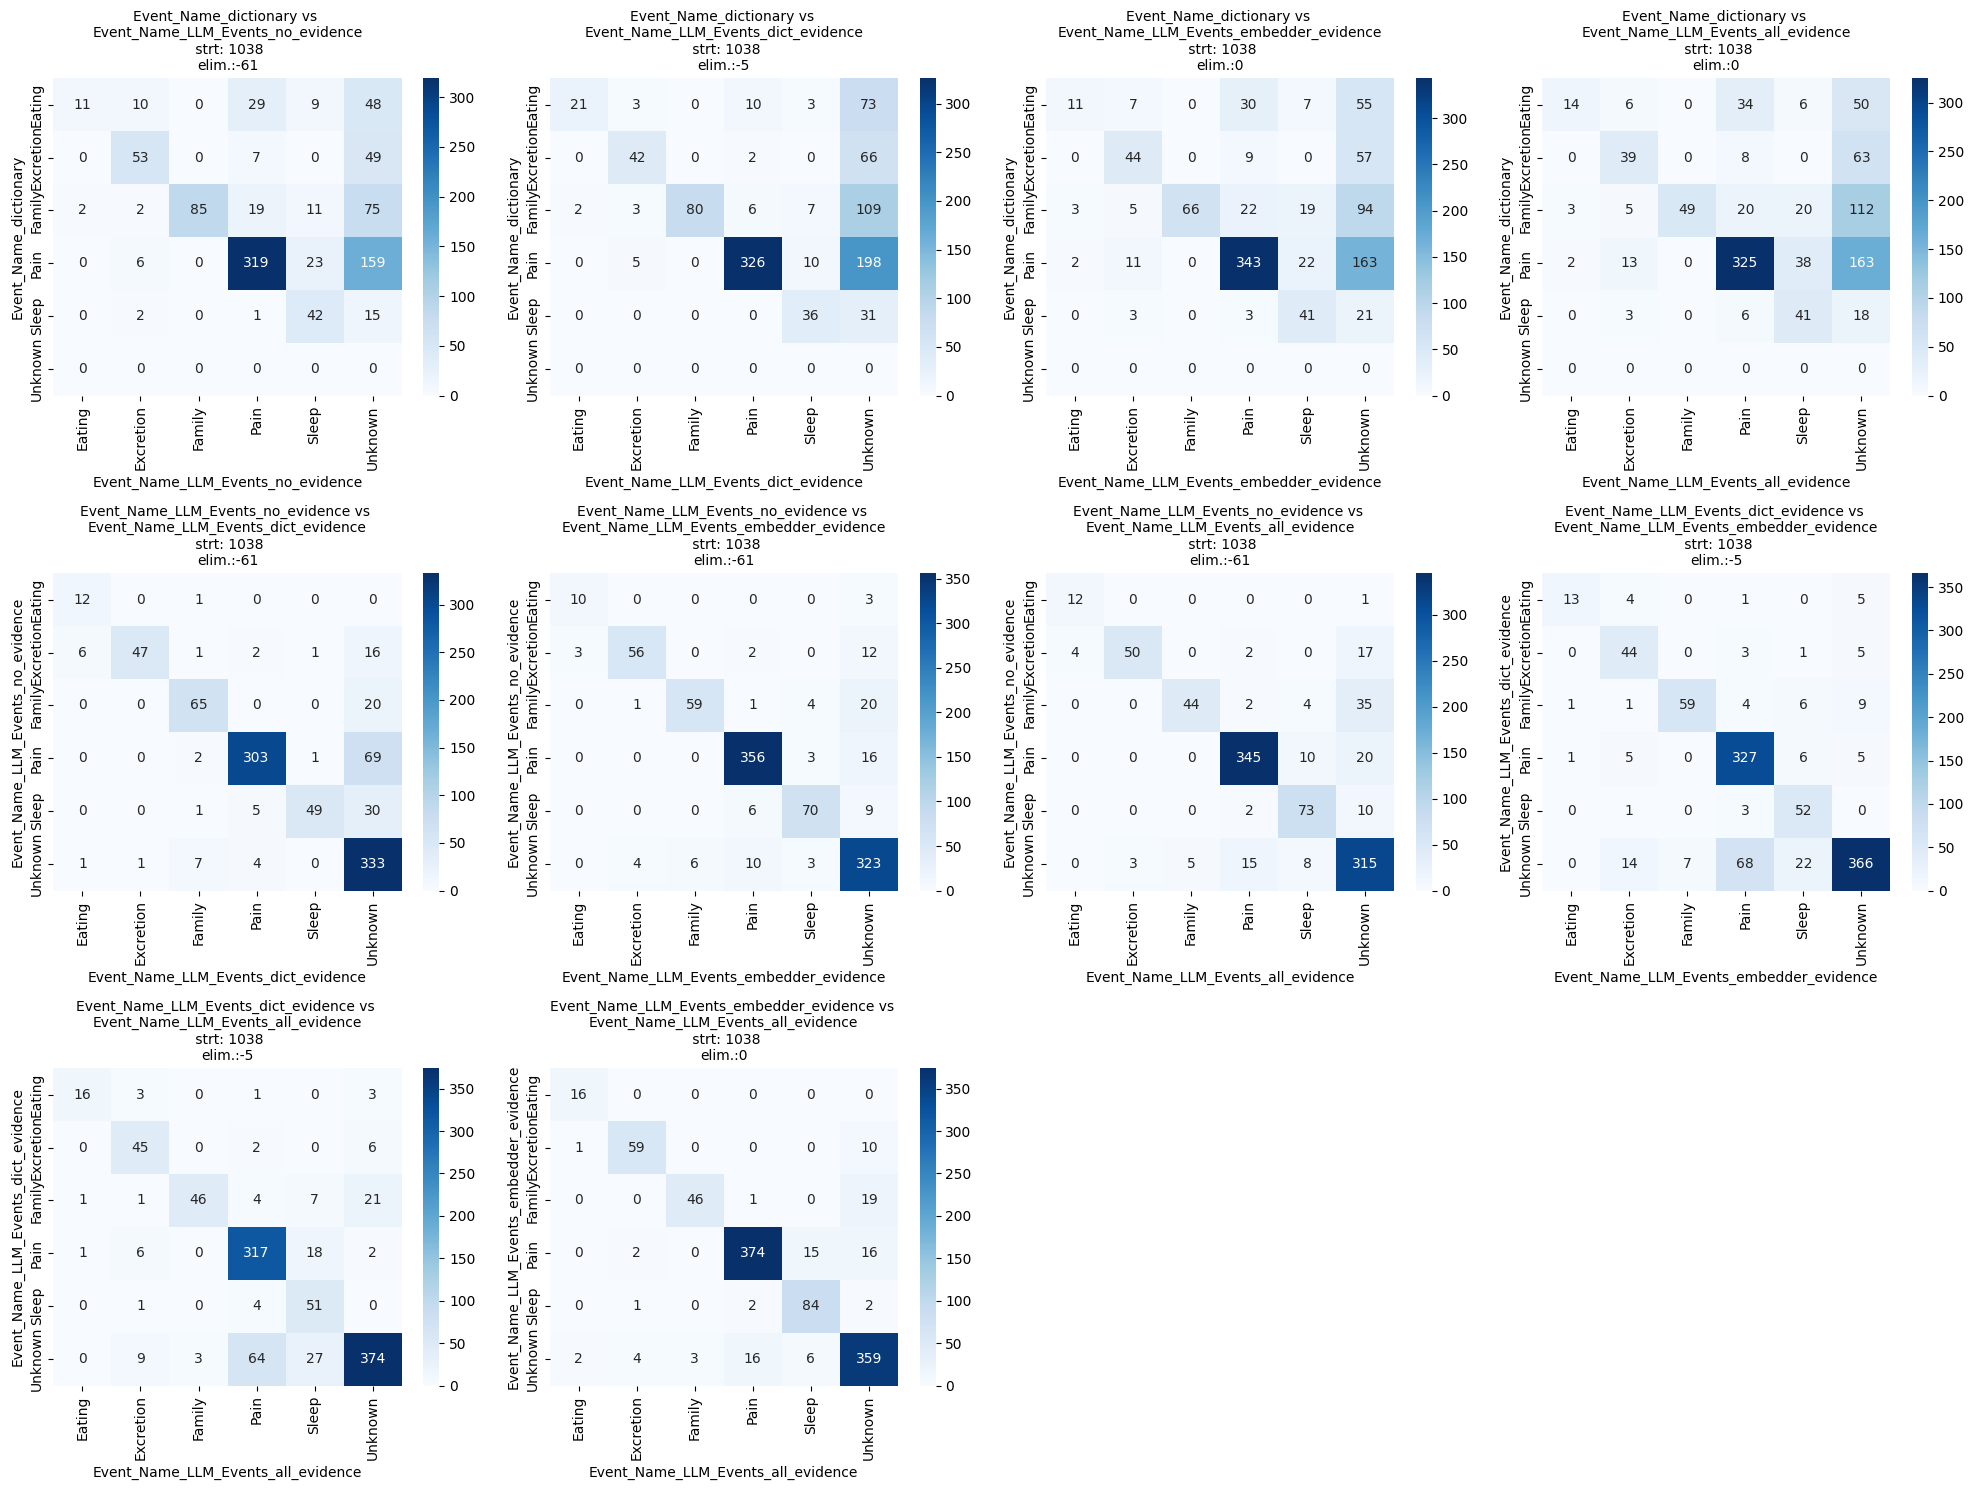

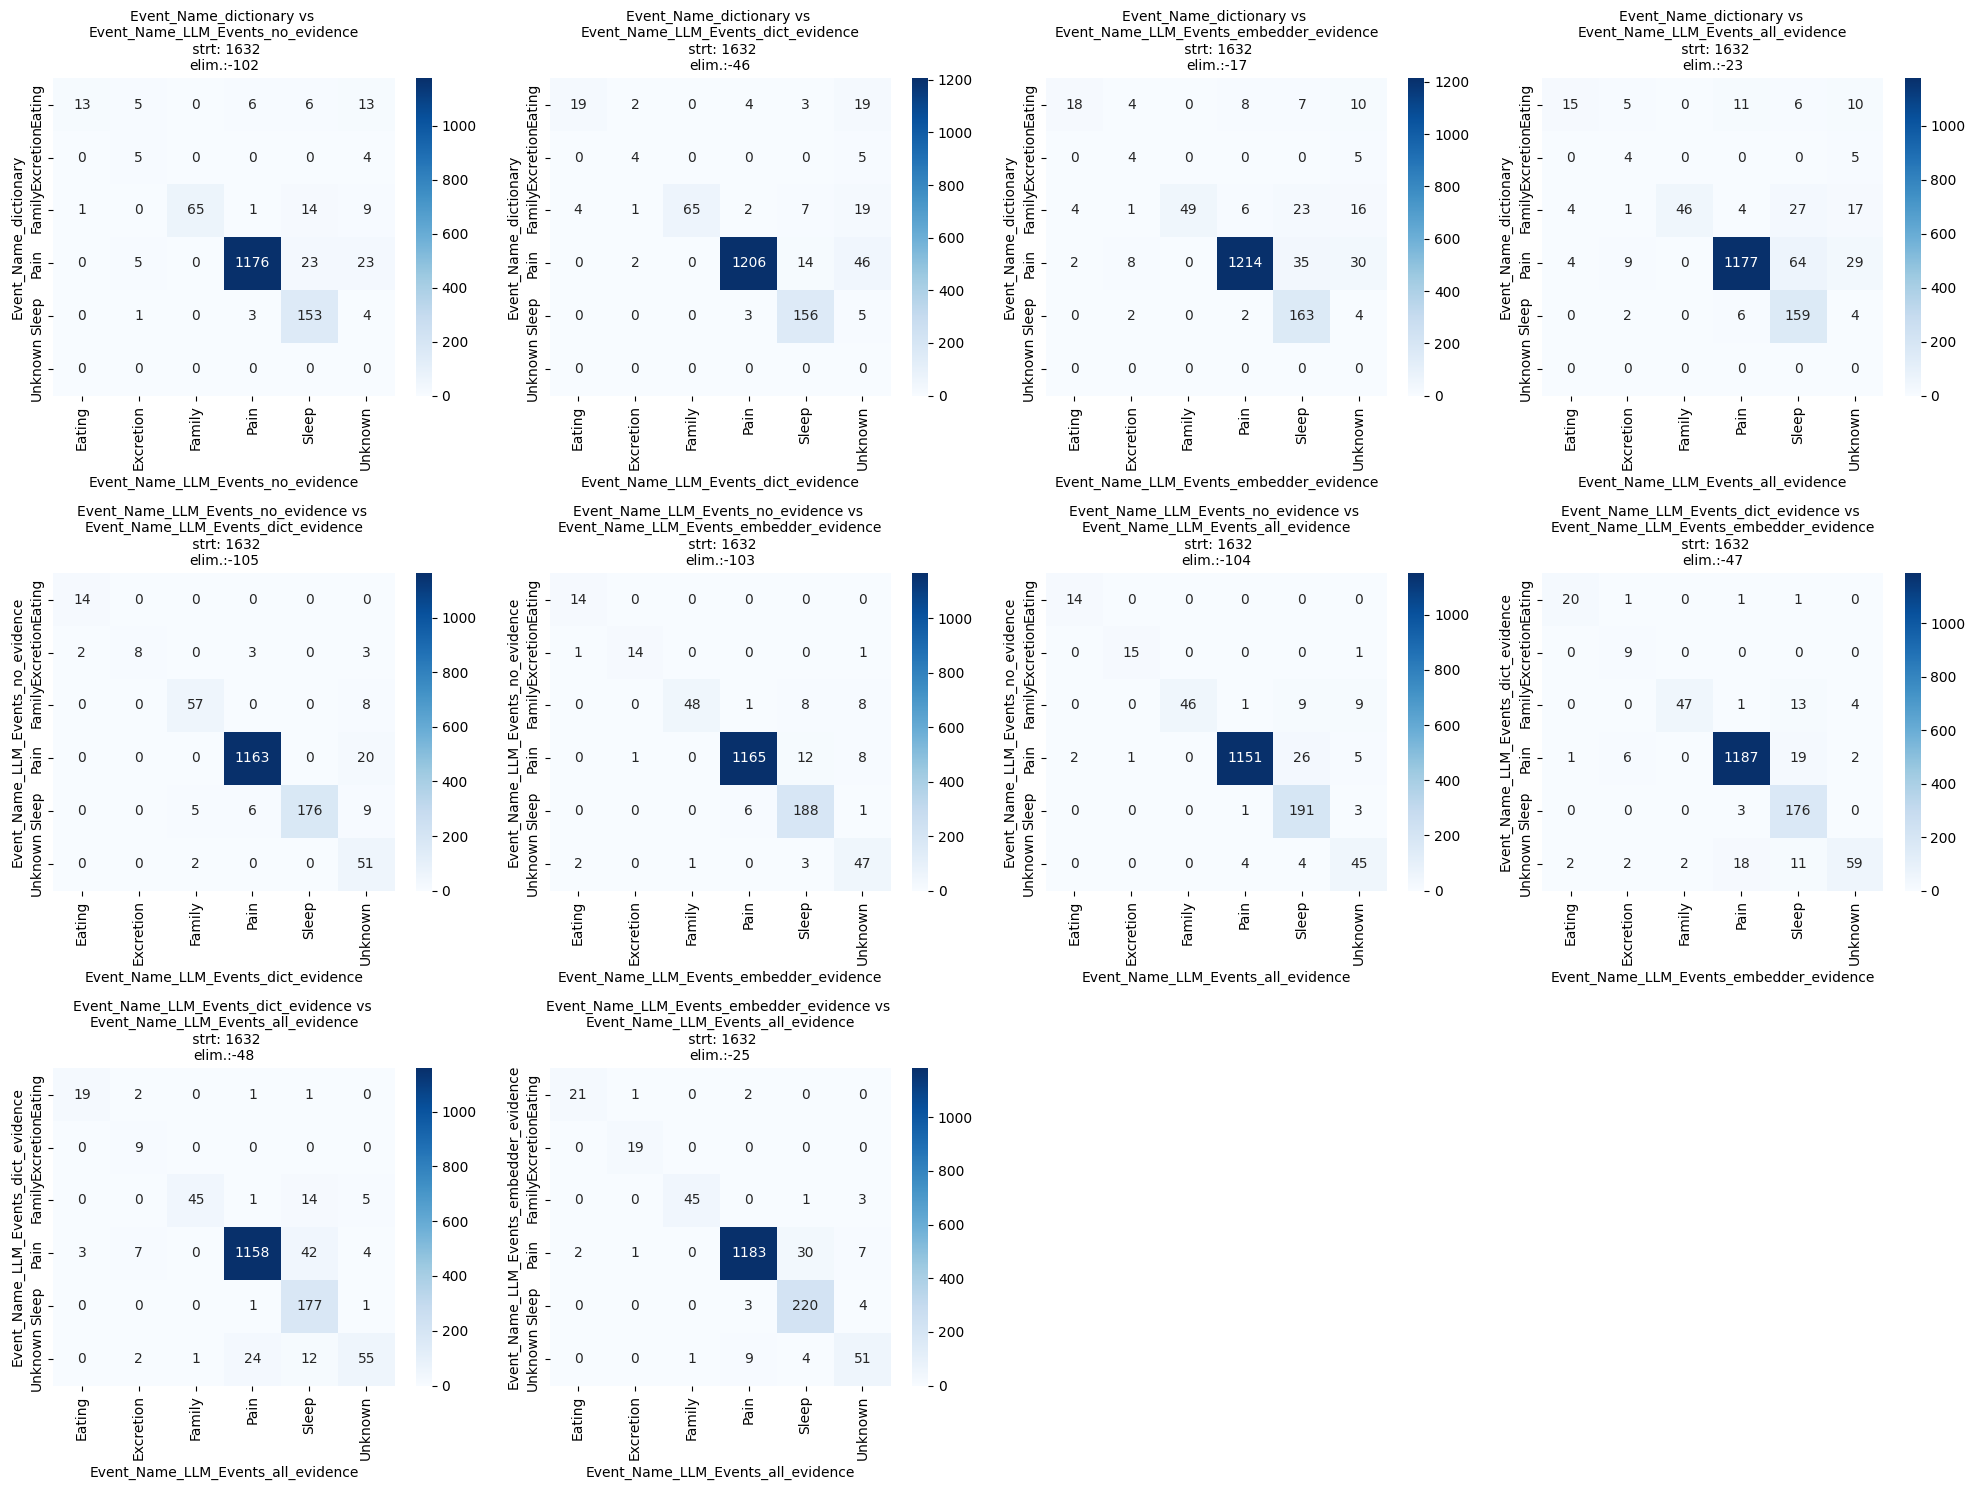

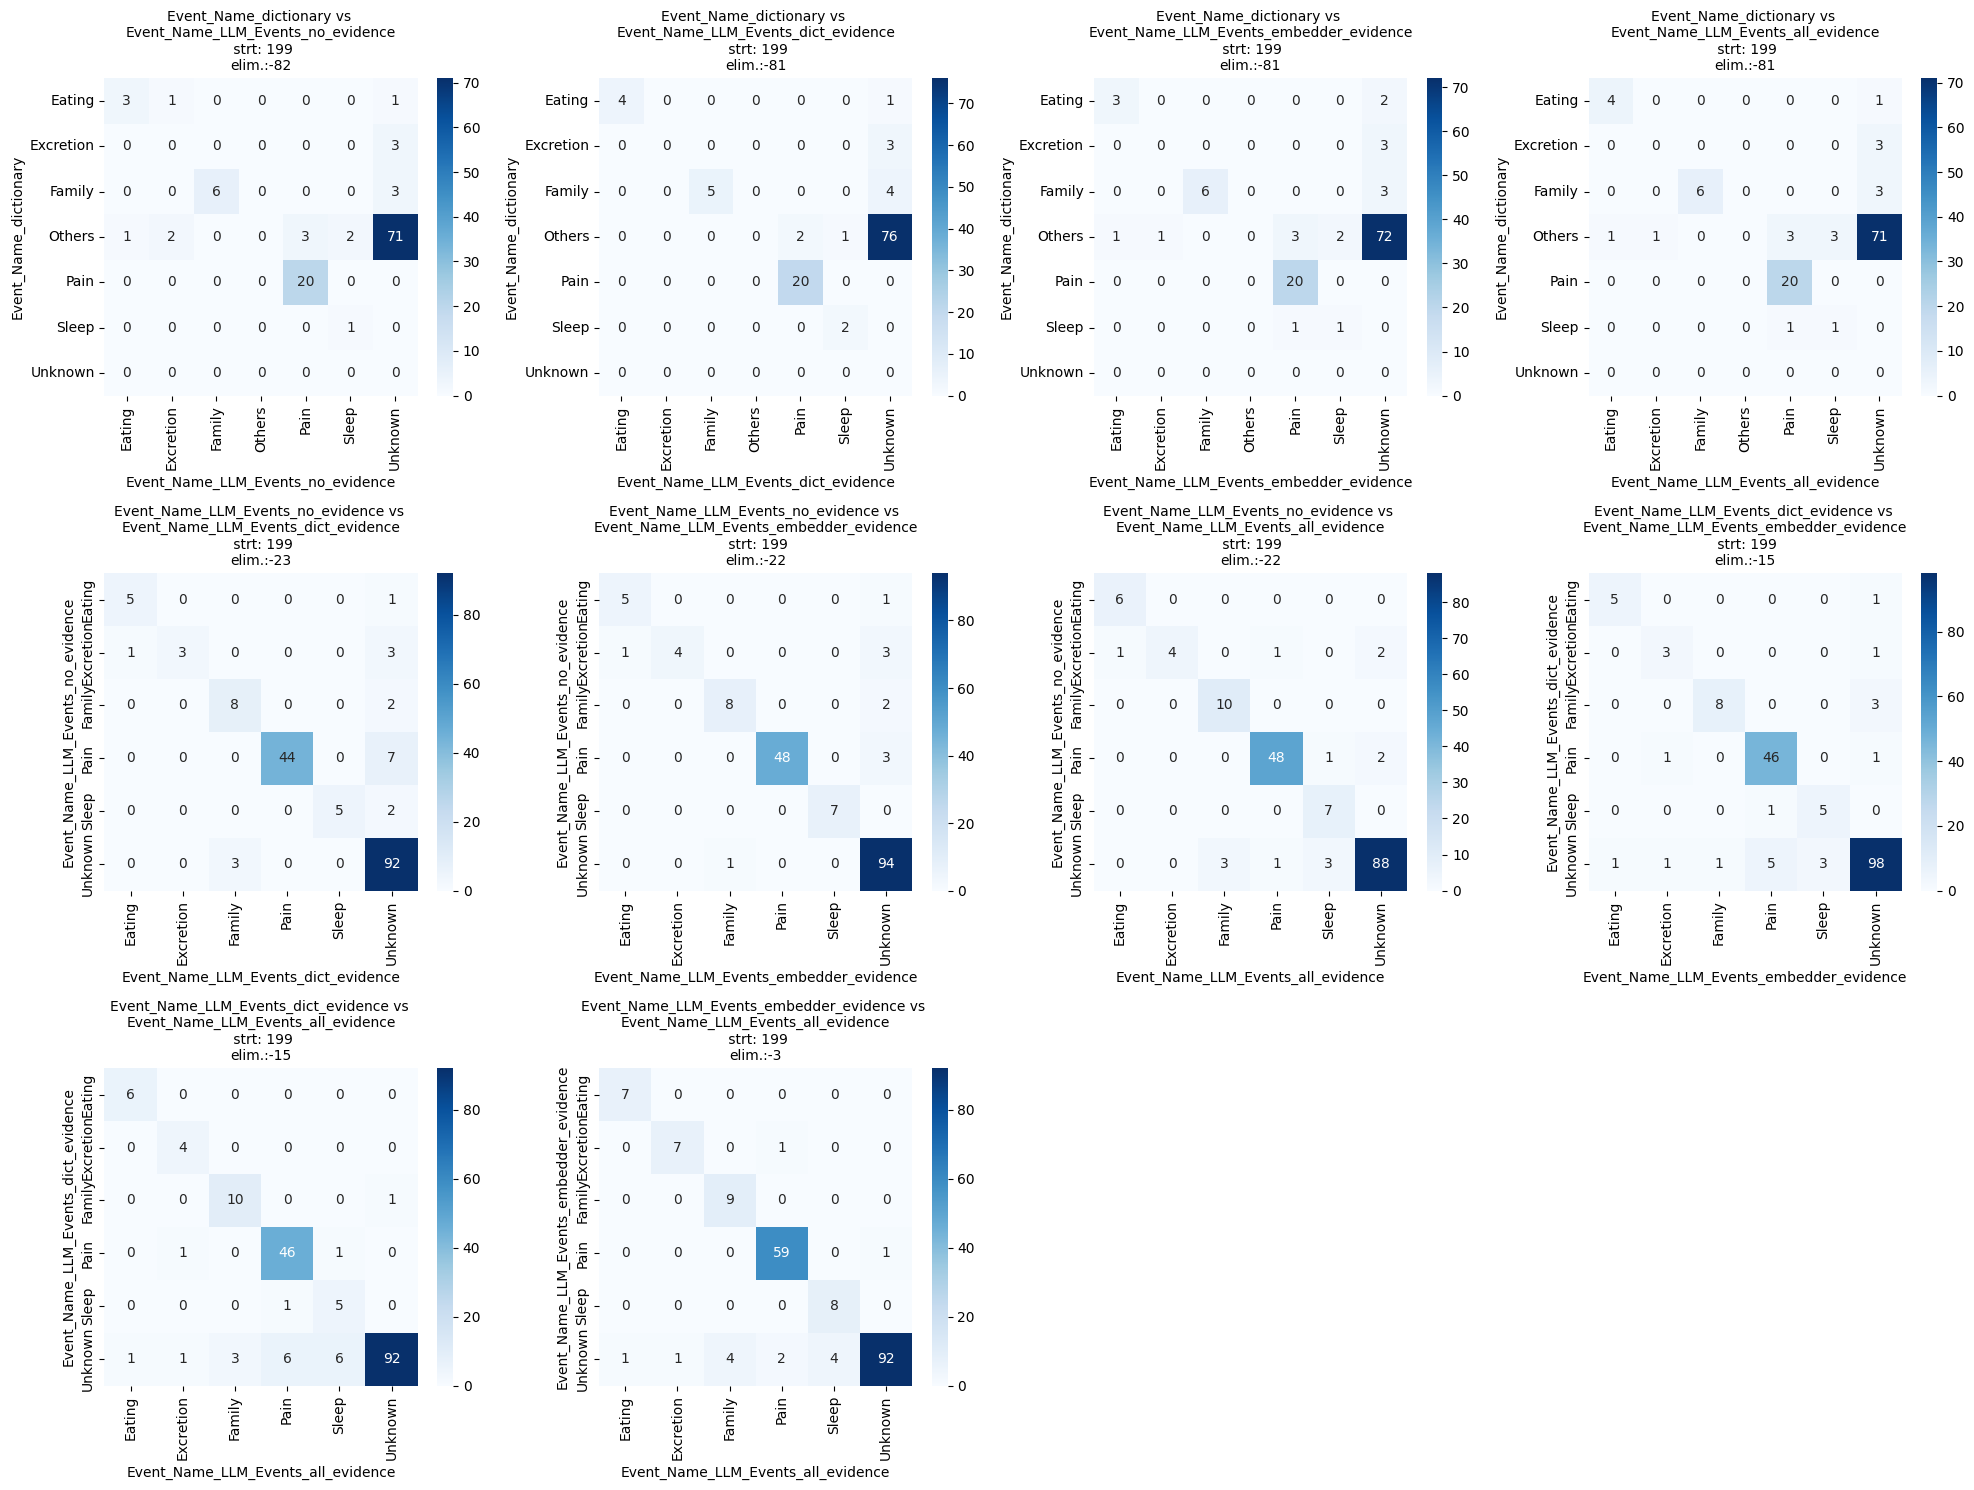

In [ ]:
import pandas as pd
import itertools
from sklearn.metrics import cohen_kappa_score
from scipy.stats import chi2_contingency

def get_cohens_kappa(df,vis_columns,remove_multi=False):
    cohenskappa_results = []

    # Pairwise comparisons
    for col1, col2 in itertools.combinations(vis_columns, 2):
        sub_df = df.copy()
        if remove_multi:
            sub_df = sub_df[sub_df.apply(lambda x: True if ("_" not in x[col1] and '_' not in x[col2]) else False, axis=1)]
        kappa = cohen_kappa_score(sub_df[col1],sub_df[col2])
        cohenskappa_results.append({
            'Column 1': col1,
            'Column 2': col2,
            'Cohen\'s Kappa': kappa
        })
    cohenskappa_results_df = pd.DataFrame(cohenskappa_results)
    return cohenskappa_results_df



def get_chisquare(df, vis_columns):
    chi2_results = []

    for col1, col2 in itertools.combinations(vis_columns, 2):
        # Drop NA values to avoid errors
        sub_df = df[[col1, col2]].dropna()

        # Create contingency table
        contingency = pd.crosstab(sub_df[col1], sub_df[col2])

        # Run Chi-Square test
        chi2, p, _, _ = chi2_contingency(contingency)

        chi2_results.append({
            'Column 1': col1,
            'Column 2': col2,
            'Chi2 Stat': chi2,
            'p-value': p
        })

    chi2_df = pd.DataFrame(chi2_results)
    return chi2_df.sort_values("p-value")
 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

def plot_confusion_matrices_for_column_pairs(df, vis_columns):
    pairs = list(itertools.combinations(vis_columns, 2))
    n_pairs = len(pairs)

    # Determine layout: square-ish grid
    n_cols = int(np.ceil(np.sqrt(n_pairs)))
    n_rows = int(np.ceil(n_pairs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for idx, (col1, col2) in enumerate(pairs):
        ax = axes[idx]
        
        # Drop rows with missing values in either column
        sub_df = df[[col1, col2]].dropna().copy()
        start_length = len(sub_df)
        sub_df = sub_df[sub_df.apply(lambda x: True if ("_" not in x[col1] and '_' not in x[col2]) else False, axis=1)]
        filter_length = len(sub_df)
        # Get confusion matrix
        labels = sorted(set(sub_df[col1]) | set(sub_df[col2]))
        cm = confusion_matrix(sub_df[col1], sub_df[col2], labels=labels)

        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(f"{col1} vs \n{col2}\n strt: {start_length}\nelim.:{filter_length-start_length}", fontsize=10)
        ax.set_xlabel(col2)
        ax.set_ylabel(col1)

    # Hide any extra axes
    for j in range(len(pairs), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    return fig
    
event_types = ["Pain", "Sleep", "Excretion", "Eating", "Family"]
vis_columns = ['Event_Name_dictionary','Event_Name_LLM_Events_no_evidence','Event_Name_LLM_Events_dict_evidence','Event_Name_LLM_Events_embedder_evidence','Event_Name_LLM_Events_all_evidence']
keep_columns = ['Event_Name_dictionary',"Similarity",'Event_Name_LLM_Events_no_evidence','Event_Name_LLM_Events_dict_evidence','Event_Name_LLM_Events_embedder_evidence','Event_Name_LLM_Events_all_evidence']
for file_name in ["only_event_mention","no_particular_event_mention"]:
    disagreement_df = pd.read_pickle(f"../exports/disagreements/{file_name}.pkl")
    if file_name == "only_event_mention":
        disagreement_type = "keyword present but embedder low"
    elif file_name == "no_particular_event_mention":
        disagreement_type = "keyword absent but embedder high"
    disagreement_df['disagreement_type'] = disagreement_type
    if len(disagreement_df)<=1:
        continue
    print(file_name)
    for col in vis_columns:
        disagreement_df[col] = disagreement_df[col].apply(lambda x: "_".join(tuple(set(x))) if type(x)==list else x)
        disagreement_df[f"{col}_multi"] = disagreement_df[col].apply(lambda x: {i: x.count(i) if isinstance(x, list) else 0 for i in event_types})
        print(disagreement_df[f"{col}_multi"])
    disagreement_df.to_excel(f"../exports/disagreements/{file_name}.xlsx")
    disagreement_df.to_excel(f"../exports/disagreements/{file_name}.xlsx")
    # Store results in a DataFrame
    cohenskappa_results_df = get_cohens_kappa(disagreement_df,vis_columns, remove_multi=True)
    cohenskappa_results_df.to_excel(f"../exports/disagreements/{file_name}_cohenskappa.xlsx")
    
    chisquare_results_df = get_chisquare(disagreement_df,vis_columns)
    chisquare_results_df.to_excel(f"../exports/disagreements/{file_name}_chisquare.xlsx")
    
    plot_confusion_matrices_for_column_pairs(disagreement_df,vis_columns).savefig(f"../exports/disagreements/{file_name}_cms.png")
    

In [11]:
disagreement_df.columns

Index(['ROW_ID', 'Sent_ID', 'HADM_ID', 'CHARTTIME_dictionary',
       'STORETIME_dictionary', 'Sentence_dictionary', 'Event_Name_dictionary',
       'Keyword', 'CGID_dictionary', 'Time_dictionary', 'CHARTTIME_biolord',
       'STORETIME_biolord', 'Sentence_biolord', 'Event_Name_biolord',
       'CGID_biolord', 'Similarity', 'Eating_similarity',
       'Excretion_similarity', 'Family_similarity', 'Pain_similarity',
       'Sleep_similarity', 'Time_biolord', 'only_Pain', 'contains_Pain',
       'no_Pain', 'disagreement_only_Pain_th_0_2',
       'disagreement_no_Pain_th_0_2', 'disagreement_unknown_th_0_2',
       'disagreement_multi_th_0_2', 'only_Sleep', 'contains_Sleep', 'no_Sleep',
       'disagreement_only_Sleep_th_0_2', 'disagreement_no_Sleep_th_0_2',
       'only_Excretion', 'contains_Excretion', 'no_Excretion',
       'disagreement_only_Excretion_th_0_2',
       'disagreement_no_Excretion_th_0_2', 'only_Eating', 'contains_Eating',
       'no_Eating', 'disagreement_only_Eating_th_0_

In [5]:
disagreement_df = pd.read_pickle(f"../exports/disagreements/{file_name}.pkl")